Audio Phase as it Relates to a Loss Function for Raw Audio 
======================

I'm interested in coming up with a good distance metric, or loss function for _raw audio_.  

Naively using something like mean-squared error surely wastes tons of model capacity on things that are perceptually irrelevant or imperceptible as today's [lossy perceptual audio codecs](http://mp3.radified.com/ogg_psycho_models.htm) teach us.  

Mean-squared error also makes assumptions about the underlying data-generating distrubtion (namely, that it is Gaussian), and recent succesful attempts at audio generation have side-stepped this issue by discretizing audio samples, and treating sample prediction as a _classification_ problem, so that an arbitrary underlying distribution may be learned.  For more details see:

- [Section 2.2.1 of the SampleRNN paper](https://arxiv.org/abs/1612.07837)
- [Section 2.2 of the WaveNet paper](https://arxiv.org/pdf/1609.03499.pdf)


I'm curious about how much model capacity in say, and autoencoder or generative adversarial network (or even one of the recurrent/auto-regressive models discussed above) is wasted on perceptually irrelevant details.

The Possibility of a Learned Metric
---------------------------------------------

Can I perturb the phase of audio samples, causing mean-squared error to be high, while maintaining perceptual identity?  Can I use this knowledge to train a model to embed these identical examples close together in some new space?  Can I use this new hypothetical embedding as a learned loss to more effectively train models that generate audio?

This notebook begins to explore how to manipulate phase in perceptually irrelevant ways, but we might also add some other know psychoacoustic quirks into our arsenal for creating examples to train our hypothetical loss function, namely:

- [tonal masking](https://en.wikipedia.org/wiki/Auditory_masking#Simultaneous_masking)
- [temporal masking](https://en.wikipedia.org/wiki/Auditory_masking#Temporal_masking)
- absolute threshold of hearing

I imagine that you could use something like [triplet loss](https://www.coursera.org/learn/convolutional-neural-networks/lecture/HuUtN/triplet-loss) to train our embedding, by doing the following:

- choose an "anchor" audio sample
- choose a "positive" sample by perturbing the original sample in a pereceptually irrelevant way
- choose a "negative" example simply by picking another audio sample at random
- encourage the model to push the anchor close to the positive example, and further from the negative example in the embedding space


Getting Oriented
--------------------------
 First, let's get some audio to work with.

In [3]:
%matplotlib inline
import zounds

samplerate = zounds.SR22050()
BaseModel = zounds.stft(
    resample_to=samplerate, 
    store_resampled=True, 
    store_fft=True)

@zounds.simple_in_memory_settings
class Sound(BaseModel):
    pass

_id = Sound.process(meta='../audio/bach.ogg')
snd = Sound(_id)

Let's take one second of this audio, and start to understand changes we can make that will have little or no impact on our perception.

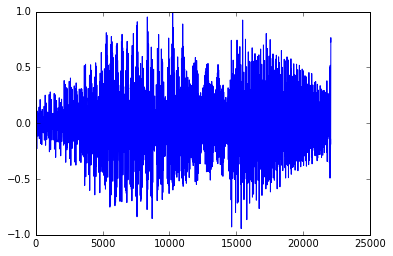

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, Audio

time_slice = zounds.TimeSlice(start=zounds.Seconds(1), duration=zounds.Seconds(1))
samples = zounds.AudioSamples(snd.resampled[time_slice], samplerate)

def scaled(x):
    return x / np.abs(x).max()

samples = scaled(samples)

plt.plot(samples)
plt.show()

Audio(samples, rate=int(samplerate))

OK, so the first thing we know is that the hair cells in the cochlea lose the abillity to lock to phase at around 5Khz, so we should be able to discard all of that phase, and hear something that sounds precisely the same.

First, let's take an FFT of the samples, and look at what we've got.

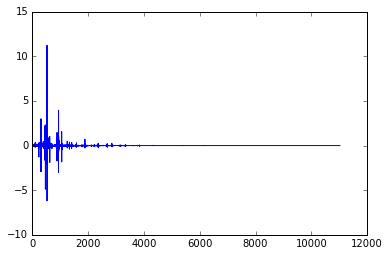

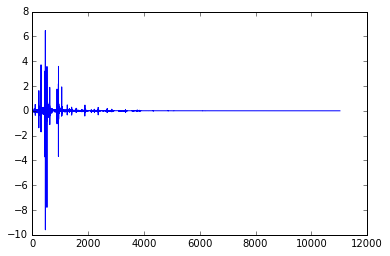

In [5]:
from zounds.spectral import fft
coeffs = np.fft.rfft(samples, norm='ortho')

# plot the magnitude
plt.plot(coeffs.real)
plt.show()

# plot the phase
plt.plot(coeffs.imag)
plt.show()

Phase Manipulation
------------------------

Let's be sure we know how to manipulate phase. Let's start with the identity transform.

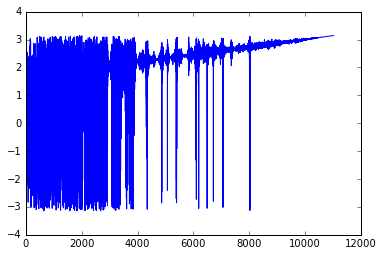

In [6]:
# get the angle of the phase
phase_in_radians = np.angle(coeffs)
plt.plot(phase_in_radians)
plt.show()

def recover_phase(radians, coeffs):
    return np.tan(radians) * coeffs.real

original_phase = recover_phase(phase_in_radians, coeffs)

def synthesize(coeffs, new_phase):
    c = coeffs.copy()
    c.imag = new_phase
    reconstructed = np.fft.irfft(c, norm='ortho')
    return scaled(zounds.AudioSamples(reconstructed, samplerate))

recon_samples = synthesize(coeffs, original_phase)

Audio(recon_samples, rate=int(samplerate))

So back to that "no phase locking above 5hz" thing.  Let's just throw away all the phase information above 5hz, and see what we get.

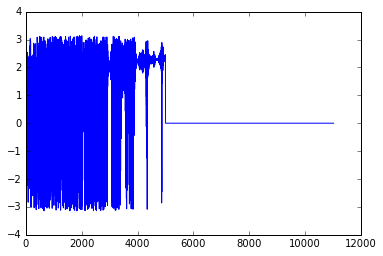

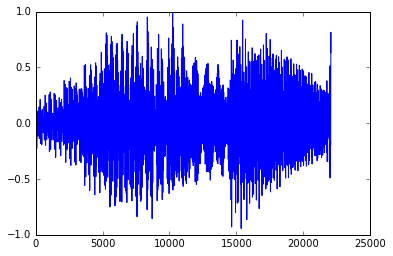

In [7]:
phase_in_radians = np.angle(coeffs)
scale = zounds.LinearScale.from_sample_rate(samplerate, len(phase_in_radians))
band = zounds.FrequencyBand(5000, 20000)
phase = zounds.ArrayWithUnits(phase_in_radians, [zounds.FrequencyDimension(scale)])

# set all the phases above 5Khz to 0
phase[band] = 0

plt.plot(phase)
plt.show()

altered_phase = recover_phase(phase, coeffs)

recon_samples = synthesize(coeffs, altered_phase)

plt.plot(recon_samples)
plt.show()

Audio(recon_samples, rate=int(samplerate))

Those sound pretty darn close to me.  Let's see what the mean-squared error is.

In [8]:
def mean_squared_error(a, b):
    return ((a - b) ** 2).mean()

display('mean squared error', mean_squared_error(samples, recon_samples))

'mean squared error'

1.5982265083322254e-06

Without another distance to compare, that first number is pretty meaningless.  Let's check the MSE of our original file against something that sounds very different, so we have a baseline.

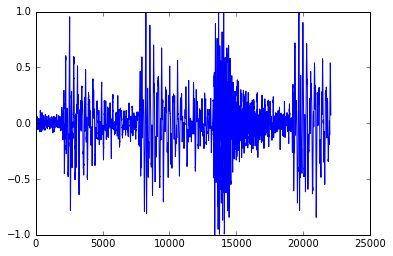

'mean squared error'

0.13332857

In [9]:
drums_id = Sound.process(meta='../audio/lovedrops.wav')
drum_snd = Sound(drums_id)
drum_samples = zounds.AudioSamples(drum_snd.resampled[time_slice], samplerate)
drum_samples = scaled(drum_samples)

plt.plot(drum_samples)
plt.show()

display('mean squared error', mean_squared_error(samples, drum_samples))
Audio(drum_samples, rate=int(samplerate))

What about the distance between our original and another slice of the Bach piece?

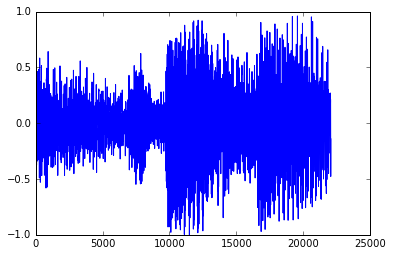

'mean squared error'

0.21818045

In [10]:
ts2 = zounds.TimeSlice(start=zounds.Seconds(10), duration=zounds.Seconds(1))
bach_samples = zounds.AudioSamples(snd.resampled[ts2], samplerate)
bach_samples = scaled(bach_samples)

plt.plot(bach_samples)
plt.show()

display('mean squared error', mean_squared_error(samples, bach_samples))
Audio(bach_samples, rate=int(samplerate))

Applying Constant Phase Shifts
-----------------------------------------

What about phases _below_ 5Khz.  Can we apply a constant shift to all of them?

First, let's make sure we know how to apply a phase shift using a toy example.

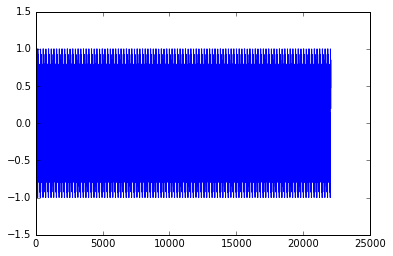

'mean squared error'

0.83254846973241314

In [11]:
synth = zounds.SineSynthesizer(samplerate)
toy = synth.synthesize(zounds.Seconds(1), [110, 220, 440, 880])
human_hearing_range = zounds.FrequencyBand(50, 5000)
toy = scaled(toy)

def phase_shift_samples(signal, time_shift, frequency_band):
    
    # compute the FFT of the signal
    coeffs = zounds.spectral.fft(signal)
    
    # shift the phase of all coefficients
    shifted_coeffs = zounds.spectral.phase_shift(
        coeffs=coeffs,
        samplerate=signal.samplerate,
        time_shift=time_shift,
        frequency_band=frequency_band)
    
    # resynthesize using the magnitudes and shifted phases
    return zounds.AudioSamples(
        np.fft.irfft(shifted_coeffs, norm='ortho'),
        signal.samplerate)
    

shifted = phase_shift_samples(
    toy, -zounds.Milliseconds(10), human_hearing_range)


plt.plot(shifted)
plt.show()

display('mean squared error', mean_squared_error(shifted, toy))
Audio(shifted, rate=int(samplerate))

So, we've got a stationary signal, and we phase shift it by a few milliseconds.  The change is imperceptible (to me, at least), but we've introduced quite a high error using our naive loss function.

Why don't we try the same thing with our original bach sample?

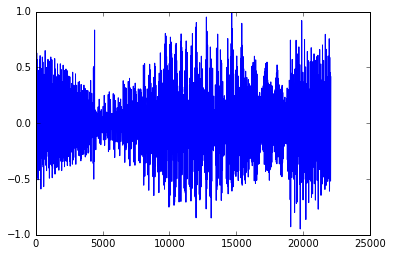

'mean squared error'

0.15163748264850524

In [12]:
bach_shifted = phase_shift_samples(
    samples, zounds.Milliseconds(100), human_hearing_range)

plt.plot(bach_shifted)
plt.show()

display('mean squared error', mean_squared_error(bach_shifted, samples))
Audio(bach_shifted, rate=int(samplerate))

Hmmm, that's actually not quite what we wanted.  We're actually "rolling" samples along the time axis, and they're wrapping back around.  If events really do happen out of order, then we expect the mean-squared error to increase.

For this, we'll need to employ the short-time Fourier transform, and only alter the phase of frequencies _within_ the short windows.

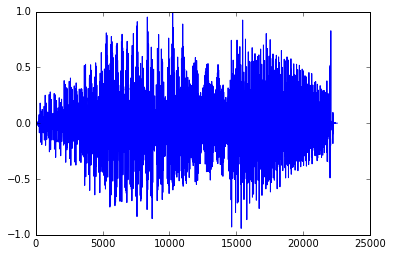

'mean squared error'

7.9099477963560003e-05

In [13]:
def phase_shift_stft(signal, time_shift, frequency_band):
    time_frequency = zounds.spectral.stft(
        signal, 
        zounds.HalfLapped(), 
        zounds.OggVorbisWindowingFunc())


    shifted_coeffs = zounds.spectral.phase_shift(
        coeffs=time_frequency,
        samplerate=signal.samplerate,
        time_shift=zounds.Milliseconds(50),
        frequency_band=band)  
    
    synth = zounds.FFTSynthesizer()
    phase_shifted = scaled(synth.synthesize(shifted_coeffs))
    return phase_shifted

phase_shifted = phase_shift_stft(
    samples, 
    zounds.Milliseconds(50), 
    zounds.FrequencyBand(20, 2000))

plt.plot(phase_shifted)
plt.show()

display('mean squared error', mean_squared_error(phase_shifted[:len(samples)], samples))
Audio(phase_shifted, rate=int(samplerate))

So, we've shifted phase _within_ the short, overlapping windows, and we've again something that sounds nearly perceptually identical, but whose distance from the original is greater than the distance between the original and a drum track, again, due to our totally naive loss function.

At this point, you might be thinking that we should take the short-time fourier transform and discard the phase entirely as a first step toward a more robust loss function, but phase _does_ matter.  

The _relationships_ between phase over time, and across frequency bins matters quite a bit, as you can hear in this next example where we randomize the phase.

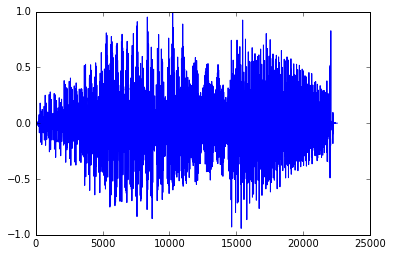

'mean squared error'

0.044517644364737208

In [14]:
time_frequency = zounds.spectral.stft(
    samples, 
    zounds.HalfLapped(), 
    zounds.OggVorbisWindowingFunc())

angles = np.random.uniform(-1, 1, time_frequency.shape)
time_frequency.imag = recover_phase(angles, time_frequency)

synth = zounds.FFTSynthesizer()
recon = synth.synthesize(time_frequency)

plt.plot(phase_shifted)
plt.show()

display('mean squared error', mean_squared_error(recon[:len(samples)], samples))
Audio(recon, rate=int(samplerate))

Notice that this very strange sounding example with its randomized phase is actually nearer to the original, again using our naive loss function.

Let's apply the constant phase shift that preserves phase relationships to one more sound, to make sure that we can rely on this transformation increasing MSE, but maintaining perceptual identity.

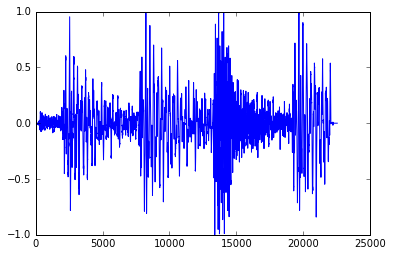

'mean squared error'

1.1603519317966712e-05

In [15]:
phase_shifted = phase_shift_stft(
    drum_samples, 
    -zounds.Milliseconds(5), 
    zounds.FrequencyBand(20, 2000))

plt.plot(phase_shifted)
plt.show()

display('mean squared error', mean_squared_error(phase_shifted[:len(drum_samples)], drum_samples))
Audio(phase_shifted, rate=int(samplerate))

Conclusion
------------------------

We've begun to make some progress toward some tools for perturbing audio in impercebtible ways.  We could use these phase perturbations (along with other possible transformations mentioned in the introduction) to _learn_ a distance metric between audio samples using something like triplet embedding loss.